# ***Simple Chatbot by LangGraph***
- ### Has Messages history
- ### Messages Summarization
- ### Tracing on LangSmith Platform

In [1]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

groq_api_key  = os.getenv("GROQ_API_KEY")

## langsmith Tracing
os.environ["LANGCHAIN_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "Chatbot With Messages Summarization"

llm = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

## Define the Messages State

In [2]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

## Define te call node how my model response to User

In [3]:
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
def call_node(state:State):
    """This node is responsible for to interact with user query with his previous messages summary if available"""
    
    summary = state.get('summary', "")
    
    if summary:
        system_msg = f"This is user previous chat history summary. Use this chat Summary to response the user query\n\n Summary: {summary}"
        
        # messages = [SystemMessage(content=system_msg)]+HumanMessage(content=state['messages'])
        messages = [SystemMessage(content=system_msg)]+state['messages']
        
    else:
        messages = state['messages']
        
    response = llm.invoke(messages)

    return {
        'messages': response
    }

## This node is responsible for Summary generation

In [4]:
def summarize_conversation(state: State):
    """This function is responsible for summarize the user conversation and remove the user previous messages except last tow conversation."""
    
    summary = state.get('summary', "")
    
    if summary:
        summary_msg = f"This is earlier messages summary: {summary}. \nExtend the summary by taking into acount the new messages above"
        
    else:
        summary_msg = f"Create s summary of the above conversation."
        
    messages = state['messages'] + [HumanMessage(content=summary_msg)]
    
    result = llm.invoke(messages)
    
    ## remove the old messages form the chat list.
    
    delete_messages = [RemoveMessage(id = m.id) for m in state['messages'][: -2]]
    
    return {
        'messages': delete_messages,
        'summary': result.content
    }

## Condition when do start summary of conversation

In [5]:
from langgraph.graph import END

def should_continue(state: State):
    """this function is responsible for when should do summarize of messages by checking messages length"""
    messages = state["messages"]
    
    if len(messages) > 6:
        return "summarize_conversation"
    return "END"

## ***Now define the graph with Checkpoint memory***

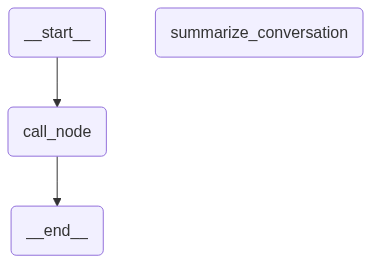

In [6]:
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

builder = StateGraph(State)

builder.add_node("call_node", call_node)
builder.add_node(summarize_conversation)

## add edges
builder.add_edge(START, "call_node")
builder.add_conditional_edges('call_node', should_continue)
builder.add_edge('summarize_conversation', END)

memory = MemorySaver()

my_graph = builder.compile(checkpointer=memory)

## display the graph
display(Image(my_graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="Assalamualikum! I'm Alamin")
output = my_graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Wa Alaikumussalam! Nice to meet you, Alamin! How are you today?


In [8]:
input_message = HumanMessage(content="what's my name?")
output = my_graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = my_graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Your name is Alamin!
================================== Ai Message ==================================

A fan of the San Francisco 49ers, eh? What's your favorite thing about the team? Is it their rich history, their iconic red and gold uniforms, or perhaps a specific player like Joe Montana or Patrick Willis?


In [9]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = my_graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Nick Bosa is an incredible player! As of 2022, he signed a 5-year, $135 million contract extension with the 49ers, which makes him one of the highest-paid defensive players in the NFL. He's definitely a key player for the team and a fan favorite! What do you think about his performance on the field?


In [10]:
my_graph.get_state(config).values.get("summary","")

"Here's a summary of our conversation:\n\n* You introduced yourself as Alamin and I responded with a warm greeting.\n* You mentioned that you like the San Francisco 49ers.\n* You expressed your admiration for Nick Bosa, a defensive player for the 49ers, and mentioned that he's one of the highest-paid defensive players in the NFL.\n\nIt was a pleasure chatting with you, Alamin! If you want to talk more about the 49ers or anything else, feel free to start a conversation anytime."